In [1]:
import json
import pandas as pd
import glob

monolingual_files = glob.glob("nbs/final_eval" + '/**/monolingual/**/*predictions.json', recursive=True)
crosslingual_files = glob.glob("nbs/final_eval" + '/**/crosslingual/**/*predictions.json', recursive=True)

d_tasks = json.load(open("data/splits/tasks.json"))
mono_gs = json.load(open("nbs/final_eval/mono_dev_gs.json"))
cross_gs = json.load(open("nbs/final_eval/cross_dev_gs.json"))

cross_preds = "official/contrastive/snowflake_mv2/crosslingual/20250131-000403/crosslingual_predictions.json"

def get_gs(d_task, task_name, d_gs):
    
    if task_name == "crosslingual":
        df_gs = pd.DataFrame({"cross": d_tasks["crosslingual"]})
    else:
        df_gs = pd.DataFrame(d_task[task_name])
        
    df_gs = df_gs.loc["posts_dev", :].reset_index().explode("posts_dev").rename(columns={"index": "lang", "posts_dev": "post_id"}).astype(str)
    df_gs["gs"] = df_gs["post_id"].map(d_gs)
    df_gs = df_gs.explode("gs")
    return df_gs

def get_preds(file):
    return pd.DataFrame(json.load(open(file))).T.apply(list, axis=1).explode().reset_index().rename(columns={"index": "post_id", 0: "pred"})

df_gs_cross = get_gs(d_tasks, "crosslingual", cross_gs)

df_cross_preds = get_preds(cross_preds)

In [2]:
# merge gs and preds in a single dataframe
df_cross = df_gs_cross.merge(df_cross_preds, on="post_id")

# for each post check if the prediction is correct
df_cross["correct"] = df_cross["gs"] == df_cross["pred"]

# take each id (each post) and check if there are any correct predictions
ls_check_inc = df_cross.groupby("post_id")["correct"].any()

# get the indexes of the posts that have incorrect predictions
ls_check_inc = ls_check_inc[~ls_check_inc].index

# get the posts that have incorrect predictions
df_check_inc = df_cross[df_cross["post_id"].isin(ls_check_inc)]
df_check_inc

,lang,post_id,gs,pred,correct
20,cross,116,106143,101502,False
21,cross,116,106143,104228,False
22,cross,116,106143,68966,False
23,cross,116,106143,167778,False
24,cross,116,106143,104307,False
...,...,...,...,...,...
6375,cross,27558,86293,91030,False
6376,cross,27558,86293,150274,False
6377,cross,27558,86293,90987,False
6378,cross,27558,86293,141885,False


In [36]:
from src.datasets import TextConcatPosts, TextConcatFactCheck
from src import config
posts_path = config.POSTS_PATH
tasks_path = config.PHASE1_TASKS_PATH
task_name = "crosslingual"
fact_checks_path = config.FACT_CHECKS_PATH
lang="eng"
gs_path = config.GS_PATH

posts = TextConcatPosts(posts_path, tasks_path, task_name=task_name, gs_path=gs_path, lang=lang)
fact_checks = TextConcatFactCheck(fact_checks_path, tasks_path, task_name=task_name, lang=lang)

fact_checks_en = TextConcatFactCheck(fact_checks_path, tasks_path, task_name=task_name, lang=lang, version="english")


In [37]:
df_posts = posts.df
df_fact_checks = fact_checks.df
df_fact_checks_en = fact_checks_en.df
df_posts

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
3,"""Australia 50 MILLONES de dosis de ""vacuna"" re...",False,,fra,0,0,1,"""Australia 50 MILLONES de dosis de ""vacuna"" re...",[50973]
16,"""Estrictamente y hablando con sentido, la conq...",Partly false information,,spa,1,0,0,"""Estrictamente y hablando con sentido, la conq...",[38000]
30,"""No es necesario creer en Dios para ser una bu...",False information,,spa,1,0,0,"""No es necesario creer en Dios para ser una bu...",[3857]
60,#Artés Presidente #Save Palestine ... [USER] M...,Partly false information,,spa,1,0,0,#Artés Presidente #Save Palestine ... [USER] M...,[50802]
62,#CNN: Child soldiers are ok if they are to def...,Altered photo,,eng,1,0,0,#CNN: Child soldiers are ok if they are to def...,"[34139, 134205]"
...,...,...,...,...,...,...,...,...,...
27750,"La ""mujer"" de Macron operada de la próstata!!,...",False information,🙄,eng,1,0,0,"La ""mujer"" de Macron operada de la próstata!!,...",[]
27794,,Missing context,"🚨 NOTICIERO DE PORTUGAL : ""La inmensa mayoría ...",spa,1,0,0,"🚨 NOTICIERO DE PORTUGAL : ""La inmensa mayoría...",[]
27995,,,🤔👌ईरान के यूवक ने मक्का 🕋मे दूध चढाया ओर बोला ...,hin,1,0,0,🤔👌ईरान के यूवक ने मक्का 🕋मे दूध चढाया ओर बोला...,[]


In [5]:
df_posts = posts.df
df_fact_checks = fact_checks.df
df_posts.index = df_posts.index.astype(str)

In [6]:
d_langs_posts = df_posts["lan"].to_dict()
d_langs_fact_checks = df_fact_checks["lan"].to_dict()

In [7]:
df_cross = df_check_inc.copy()
df_cross["post_id"] = df_cross["post_id"].astype(str)
df_cross["lang_post"] = df_cross["post_id"].map(d_langs_posts)
df_cross["lang_gs"] = df_cross["gs"].map(d_langs_fact_checks)
df_cross["lang_pred"] = df_cross["pred"].map(d_langs_fact_checks)


In [8]:
df_cross.head()

,lang,post_id,gs,pred,correct,lang_post,lang_gs,lang_pred
20,cross,116,106143,101502,False,sin,eng,msa
21,cross,116,106143,104228,False,sin,eng,eng
22,cross,116,106143,68966,False,sin,eng,eng
23,cross,116,106143,167778,False,sin,eng,ara
24,cross,116,106143,104307,False,sin,eng,eng


In [9]:
# Most frequent language pairs in errors
error_lang_pairs = df_cross.groupby(["lang_post", "lang_pred"]).size().reset_index(name="count")
print("Top error language pairs:")
print(error_lang_pairs.sort_values("count", ascending=False).head(10))

Top error language pairs:
   lang_post lang_pred  count
25       hin       eng    140
49       por       por     90
54       sin       eng     74
62       spa       eng     74
69       tgl       eng     73
7        eng       eng     59
39       msa       eng     50
65       spa       por     40
46       por       eng     40
66       spa       spa     40


# Language Mismatch Analysis

In [50]:
# Calculate mismatches
df_cross["lang_post_gs_match"] = df_cross["lang_post"] == df_cross["lang_gs"]
df_cross["lang_post_pred_match"] = df_cross["lang_post"] == df_cross["lang_pred"]

# Stats
print(f"% of errors where GS language ≠ Post language: {100*(~df_cross['lang_post_gs_match']).mean():.1f}%")
print(f"% of errors where Pred language ≠ Post language: {100*(~df_cross['lang_post_pred_match']).mean():.1f}%")

% of errors where GS language ≠ Post language: 58.0%
% of errors where Pred language ≠ Post language: 85.2%


# Top Error Patterns

In [42]:
# Most frequent language pairs in errors
error_lang_pairs = df_cross.groupby(["lang_post", "lang_pred"]).size().reset_index(name="count")
print("Top error language pairs:")
error_lang_pairs.sort_values("count", ascending=False).head(10)

Top error language pairs:


,lang_post,lang_pred,count
25,hin,eng,140
49,por,por,90
54,sin,eng,74
62,spa,eng,74
69,tgl,eng,73
7,eng,eng,59
39,msa,eng,50
66,spa,spa,40
65,spa,por,40
46,por,eng,40


# Fact-Check Frequency Analysis

In [ ]:
# Get the most frequently incorrectly predicted fact-checks
fc_error_counts = df_cross["pred"].value_counts()

fc_error_counts.quantile(0.999 and a 1\)

np.float64(7.481000000000677)

In [34]:
df_fact_checks

,claim,instances,title,lan,full_text
fact_check_id,,,,,
0,Are avocados good for you?,[https://metafact.io/factchecks/175-are-avocad...,,eng,Are avocados good for you?
1,Can animals have headaches?,[https://metafact.io/factchecks/1754-can-anima...,,eng,Can animals have headaches?
2,Can we help prevent Alzheimer's with diet?,[https://metafact.io/factchecks/173-can-we-hel...,,eng,Can we help prevent Alzheimer's with diet?
3,Do any benefits of alcohol outweigh the risks?,[https://metafact.io/factchecks/172-do-any-ben...,,eng,Do any benefits of alcohol outweigh the risks?
4,Does acupuncture work for headaches?,[https://metafact.io/factchecks/1752-does-acup...,,eng,Does acupuncture work for headaches?
...,...,...,...,...,...
205744,🇫🇷 في فرنسا ، يقرر رجال الشرطة العسكرية والمدن...,[https://factuel.afp.com/ar/French-police-demo...,هذا الفيديو ليس لتحرّك الشرطة الفرنسيّة ضدّ ال...,ara,هذا الفيديو ليس لتحرّك الشرطة الفرنسيّة ضدّ ال...
205745,👆This little beautiful girl was seen in Mangal...,[https://youturn.in/articles/child-in-mangalor...,மங்களூரில் பிச்சை எடுக்கும் குழுவில் மீட்கப்பட...,eng,மங்களூரில் பிச்சை எடுக்கும் குழுவில் மீட்கப்பட...
205747,📌إيطاليين و أجانب رجال و نساء ، أطفال و عجزة ا...,[https://factuel.afp.com/ar/this-photo-shows-a...,هذه الصور لطابورٍ أمام مركز توزيع مساعدات غذائ...,ara,هذه الصور لطابورٍ أمام مركز توزيع مساعدات غذائ...


In [40]:

# Reset the index and rename columns for clarity
fc_error_counts_reset = fc_error_counts.reset_index()
fc_error_counts_reset.columns = ["fact_check_id", "error_count"]  # Rename columns

# Merge with df_fact_checks to get the texts of these fact-checks
frequent_errors_with_text = fc_error_counts_reset.merge(
    df_fact_checks_en[["lan", "full_text"]], 
    left_on="fact_check_id", 
    right_index=True, 
    how="left"
)

# Display the fact-check texts
print("Most frequently incorrectly predicted fact-checks and their texts:")
for _, row in frequent_errors_with_text.iterrows():
    print(f"\nFact-Check ID: {row['fact_check_id']}")
    print(f"Frequency of Errors: {row['error_count']}")
    print(f"Language: {row['lan']}")
    print(f"Text: {row['full_text']}")
    print("----")

Most frequently incorrectly predicted fact-checks and their texts:

Fact-Check ID: 173062
Frequency of Errors: 9
Language: ara
Text: This clip is just a scene, not a recent confrontation in Brazil Video of confrontations in Brazil
----

Fact-Check ID: 132271
Frequency of Errors: 8
Language: eng
Text: This video has circulated online since November 2015 This video has circulated online since at least November 2015
----

Fact-Check ID: 52200
Frequency of Errors: 5
Language: eng
Text: Headline was digitally altered, does not come from a Nigerian TV channel Embarrassing headline by a Nigerian news channel
----

Fact-Check ID: 100328
Frequency of Errors: 5
Language: por
Text: Post with guidance on how to get emergency aid contains errors Paper delivered to a box agency guides on emergency aid
----

Fact-Check ID: 104307
Frequency of Errors: 4
Language: eng
Text: This photo shows a security guard in Malaysia having a meal Photo shows man in Sri Lanka having austere meal
----

Fact-Check ID: 

# Clustering posts

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Combine post and fact-check texts for clustering

d_ft = df_posts["full_text"].to_dict()
d_ft = {str(k): v for k, v in d_ft.items()}

df_cross["post_text"] = df_cross["post_id"].map(d_ft)
df_cross["fc_text"] = df_cross["pred"].map(df_fact_checks["full_text"])

# Extract texts for clustering
texts = df_cross.groupby("post_id")["post_text"].first().tolist()
texts


[' Está acontecendo a maior fraude eleitoral! . . . . . . #donaldtrump #trump #RenatoBarros #Questionese #eleiçõesamericana',
 '8. NEWSNOW #8NN 8 News NOW [USER]. 12h \'TURNING POINT\': British health authorities rolled out the first doses of a widely tested and independently reviewed #COVID19 vaccine Tuesday, starting a global immunization program that is expected to gain momentum as more serums win approval. #8NN Ch \'Turning point\': UK giving 1st doses of COVID-19 vaccine 8newsnow.com BBC NEWS Covid-19 vaccine: First person receives Pfizer jab in UK Ⓒ 08 December 2020 UK 01:20 CAN A UK grandmother has become the first perso the world to be given the Pfizer Covid-19 jab a part of a mass vaccination programme. cnn.com Live TV Faulty US Covid-19 respons meant 130,000 to 210,000 avoidable deaths, report fin By Maggie Fox, CNN Updated 1:42 PM EDT, Thu October 22, 2020 CORONAV PANDEMI IN THE UNITED TOTAL CASES 15,067 TOTAL DEATHS 285,1 | SALE MARE APAR SUNGAYON CHER HA CORONAVIRUS PANDEM

Cluster distribution:
   cluster  count
0        2    770
1        1    470
2        3    100
3        0     90


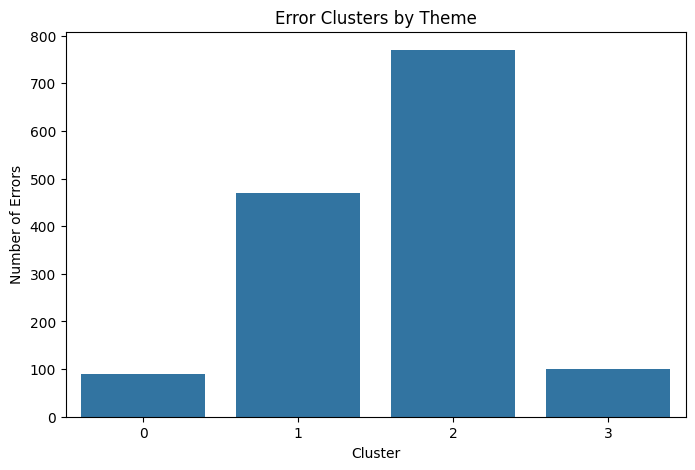

In [55]:

# Vectorize texts using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(texts)

# Perform K-Means clustering
n_clusters = 4  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame 
cluster_counts = pd.DataFrame({"post_id": df_cross["post_id"].unique(), "cluster": clusters})
df_cross = df_cross.merge(cluster_counts, on="post_id")

# Display cluster distribution
cluster_counts = df_cross["cluster"].value_counts().reset_index()
cluster_counts.columns = ["cluster", "count"]

print("Cluster distribution:")
print(cluster_counts)

# Visualize cluster distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_counts, x="cluster", y="count")
plt.title("Error Clusters by Theme")
plt.xlabel("Cluster")
plt.ylabel("Number of Errors")
plt.show()

In [56]:
# Get top keywords for each cluster
def get_top_keywords(cluster, n_keywords=20):
    cluster_indices = np.where(clusters == cluster)[0]
    cluster_texts = [texts[i] for i in cluster_indices]
    tfidf_matrix = vectorizer.transform(cluster_texts)
    tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = tfidf_scores.argsort()[-n_keywords:][::-1]
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    return top_keywords

# Display top keywords for each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} Keywords:")
    print(get_top_keywords(cluster))


Cluster 0 Keywords:
['کے', 'ہے', 'میں', 'کی', 'کو', 'کر', 'روپے', 'سے', 'کا', 'سکتی', 'امین', 'کشمیر', 'url', 'یہ', 'تو', 'کل', 'گیا', 'افواج', 'اج', 'گئیں']

Cluster 1 Keywords:
['url', 'que', 'la', 'en', 'el', 'los', 'user', 'es', 'se', 'com', 'del', 'más', 'las', 'para', 'le', 'ahora', 'des', '19', 'durante', 'por']

Cluster 2 Keywords:
['नह', 'रह', 'di', 'कर', 'बन', 'इस', 'යන', 'अपन', 'like', 'मन', 'पर', '10', 'trump', 'virus', 'dan', 'කරන', 'අන', 'page', 'está', 'ලක']

Cluster 3 Keywords:
['na', 'sa', 'ng', 'ang', 'kahit', 'ito', 'mga', 'hindi', '53', 'taal', 'sakit', 'kung', 'gobyerno', '11', 'rules', 'apoy', 'companies', 'kaya', 'yung', 'pa']


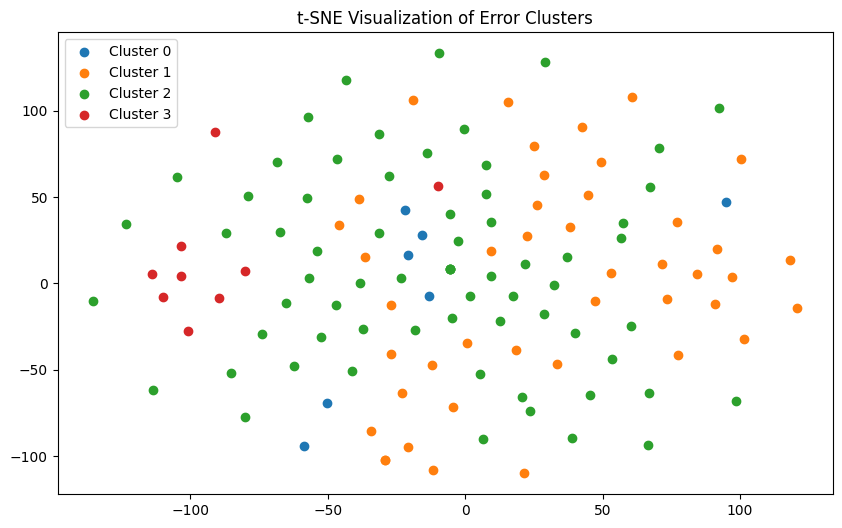

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(X_tsne[clusters == cluster, 0], X_tsne[clusters == cluster, 1], label=f"Cluster {cluster}")
plt.title("t-SNE Visualization of Error Clusters")
plt.legend()
plt.show()

# Clustering fact checks

Cluster distribution:
   cluster  count
0        1    824
1        3    276
2        2    189
3        0    141


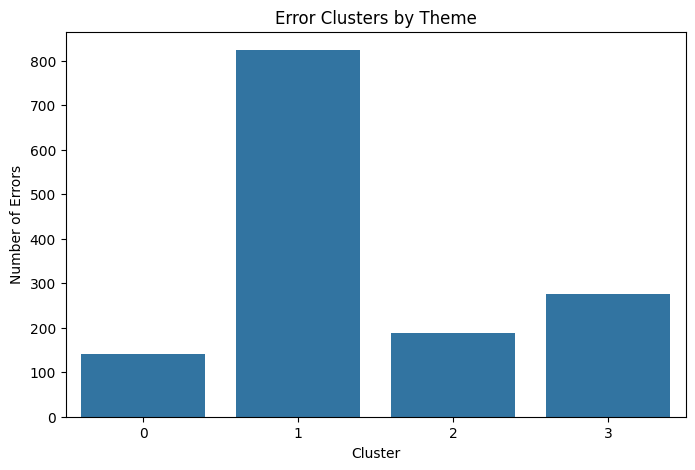

In [58]:
# Extract texts for clustering
texts = df_cross["fc_text"]

# Vectorize texts using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(texts)

# Perform K-Means clustering
n_clusters = 4  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame 
df_cross["cluster"] = clusters

# Display cluster distribution
cluster_counts = df_cross["cluster"].value_counts().reset_index()
cluster_counts.columns = ["cluster", "count"]

print("Cluster distribution:")
print(cluster_counts)

# Visualize cluster distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_counts, x="cluster", y="count")
plt.title("Error Clusters by Theme")
plt.xlabel("Cluster")
plt.ylabel("Number of Errors")
plt.show()

In [59]:
# Get top keywords for each cluster
def get_top_keywords(cluster, n_keywords=20):
    cluster_indices = np.where(clusters == cluster)[0]
    cluster_texts = [texts[i] for i in cluster_indices]
    tfidf_matrix = vectorizer.transform(cluster_texts)
    tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = tfidf_scores.argsort()[-n_keywords:][::-1]
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    return top_keywords

# Display top keywords for each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} Keywords:")
    print(get_top_keywords(cluster))


Cluster 0 Keywords:
['covid', '19', 'vaccine', 'vaccines', 'photo', 'contra', 'shows', 'sri', 'video', 'health', 'cure', 'coronavirus', 'pfizer', 'claims', 'com', 'hospital', 'vacinas', 'viral', 'false', 'spike']

Cluster 1 Keywords:
['في', 'photo', 'em', 'não', 'que', 'هذا', 'da', 'para', 'bolsonaro', 'image', 'foto', 'shows', 'lula', 'من', 'vídeo', 'على', 'هذه', 'ولا', 'com', 'mostra']

Cluster 2 Keywords:
['en', 'la', 'el', 'una', 'que', 'es', 'por', 'del', 'cette', 'las', 'los', 'des', 'les', 'montre', 'pas', 'ne', 'son', 'coronavirus', 'une', 'se']

Cluster 3 Keywords:
['video', 'shows', 'india', 'circulated', 'indian', 'chinese', 'modi', 'old', 'pakistan', 'di', 'muslim', 'shared', 'online', 'man', 'hindu', 'reports', 'protest', 'china', 'army', 'viral']


In [70]:
lang_errors = df_cross[~df_cross['correct']]
pred_gs_lang_err = lang_errors.groupby(["lang_post", "lang_pred", "lang_gs"]).size().reset_index(name="count").sort_values("count", ascending=False)
pred_gs_lang_err.head(20)

,lang_post,lang_pred,lang_gs,count
33,hin,eng,eng,140
65,por,por,por,85
72,sin,eng,eng,74
91,tgl,eng,eng,73
82,spa,eng,spa,62
88,spa,spa,spa,37
86,spa,por,spa,37
112,urd,eng,eng,36
10,eng,eng,eng,33
40,kor,eng,eng,31


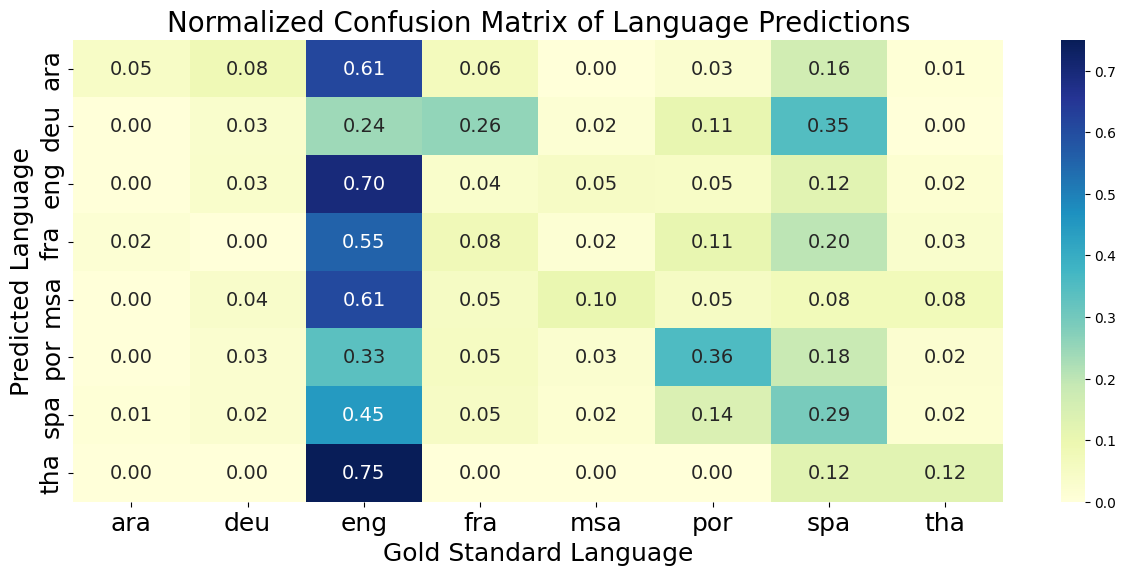

In [91]:
# Create a pivot table for the confusion matrix
title_fontsize = 20
xtick_fontsize = 18
ytick_fontsize = 18

pivot = df.pivot_table(index='lang_pred', columns='lang_gs', values='count', aggfunc='sum', fill_value=0)

# Normalize the pivot table row-wise so that each row sums to 1
pivot_normalized = pivot.div(pivot.sum(axis=1), axis=0)

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_normalized, annot=True, fmt=".2f", cmap="YlGnBu", annot_kws={"fontsize": 14})
plt.xlabel("Gold Standard Language", fontsize=xtick_fontsize)
plt.ylabel("Predicted Language", fontsize=ytick_fontsize)
plt.title("Normalized Confusion Matrix of Language Predictions", fontsize=title_fontsize)
plt.xticks(fontsize=xtick_fontsize)
plt.yticks(fontsize=ytick_fontsize)
plt.savefig("nbs/data_exploration/plots/confusion_matrix_lang_predictions.png", bbox_inches="tight")

plt.show()

In [76]:
pred_gs_lang_err[pred_gs_lang_err["lang_post"].isin(["eng", "spa", "hin"])].sort_values(["lang_post", "lang_pred", "count"], ascending=False)

,lang_post,lang_pred,lang_gs,count
88,spa,spa,spa,37
87,spa,spa,eng,3
86,spa,por,spa,37
85,spa,por,eng,3
84,spa,msa,spa,6
83,spa,fra,spa,13
82,spa,eng,spa,62
81,spa,eng,eng,12
80,spa,deu,spa,22
79,spa,deu,eng,2


Most common language mismatches (post_lang, gs_lang, pred_lang):
('hin', 'eng', 'eng'): 140
('por', 'por', 'por'): 85
('sin', 'eng', 'eng'): 74
('tgl', 'eng', 'eng'): 73
('spa', 'spa', 'eng'): 62
('spa', 'spa', 'spa'): 37
('spa', 'spa', 'por'): 37
('urd', 'eng', 'eng'): 36
('eng', 'eng', 'eng'): 33
('kor', 'eng', 'eng'): 31


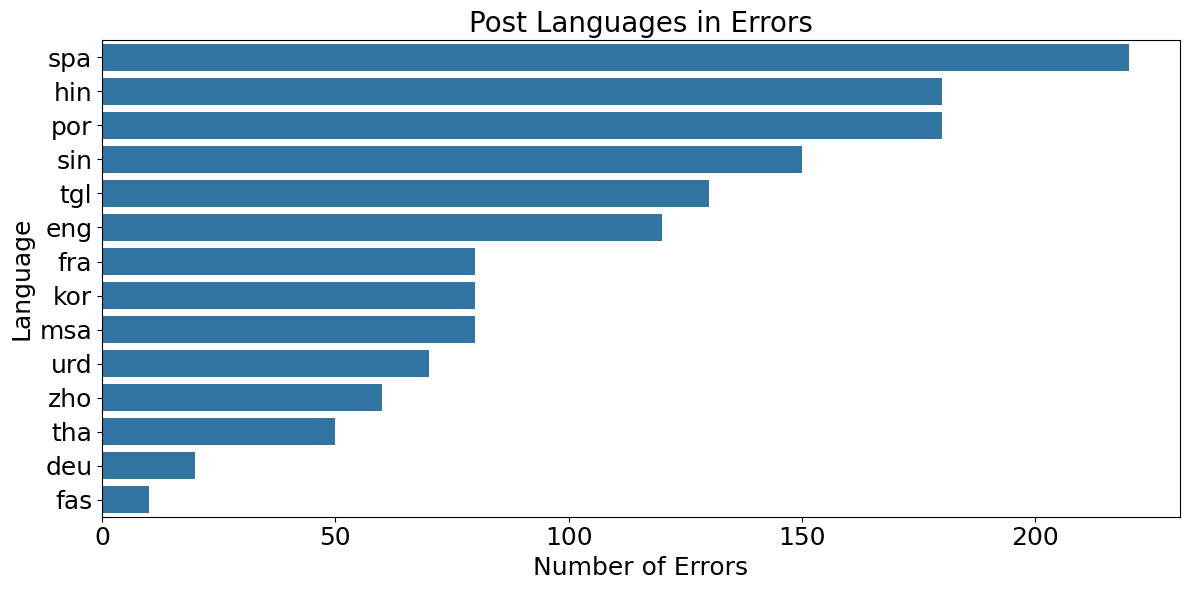

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Analyze language mismatches
lang_errors = df_cross[~df_cross['correct']]
lang_mismatch_counts = Counter()

for _, row in lang_errors.iterrows():
    lang_mismatch_counts[(row['lang_post'], row['lang_gs'], row['lang_pred'])] += 1

# Display most common language mismatches
print("Most common language mismatches (post_lang, gs_lang, pred_lang):")
for mismatch, count in lang_mismatch_counts.most_common(10):
    print(f"{mismatch}: {count}")

title_fontsize = 20
xtick_fontsize = 18
ytick_fontsize = 18

# Visualize language distribution in errors
plt.figure(figsize=(12, 6))
sns.countplot(y='lang_post', data=lang_errors, order=lang_errors['lang_post'].value_counts().index)
plt.title('Post Languages in Errors', fontsize=title_fontsize)
plt.xlabel('Number of Errors', fontsize=xtick_fontsize)
plt.ylabel('Language', fontsize=ytick_fontsize)
plt.xticks(fontsize=xtick_fontsize)
plt.yticks(fontsize=ytick_fontsize)

plt.tight_layout()
plt.savefig("nbs/data_exploration/plots/postlangsinerrors.png")
plt.show()


# post lenght

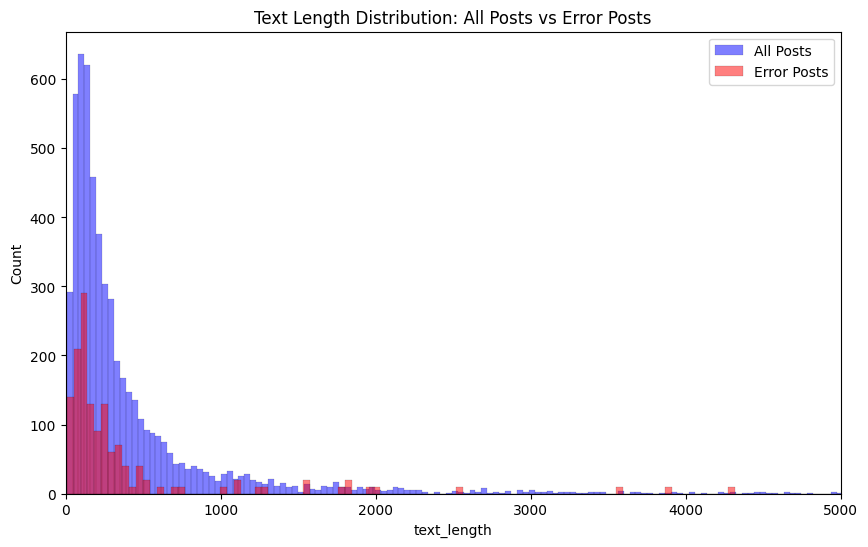

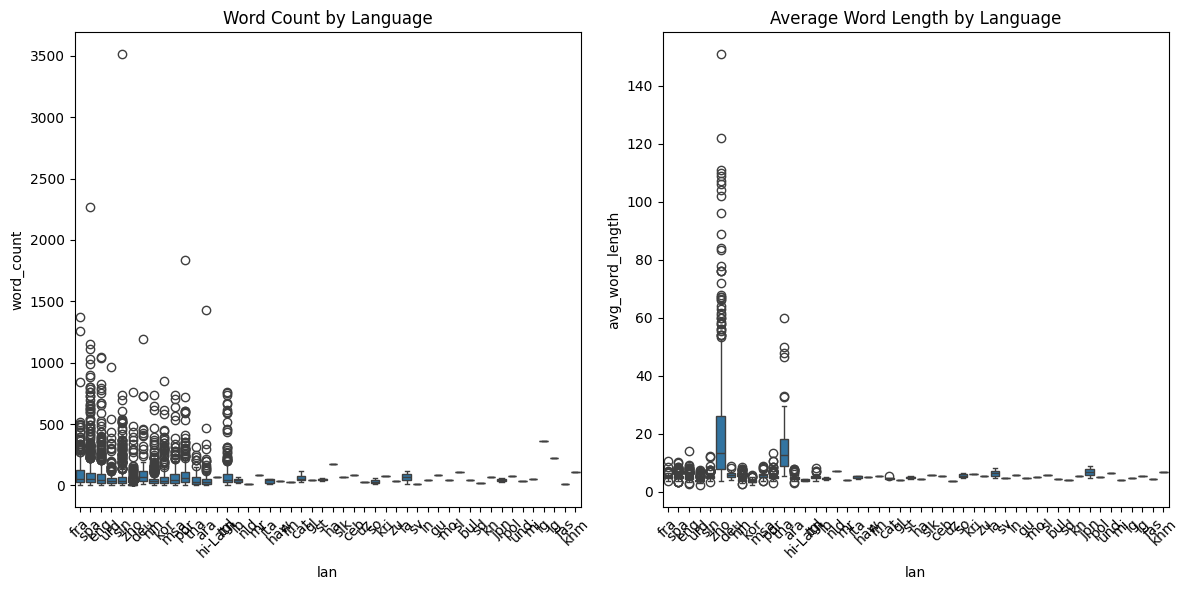

In [61]:
# Add text length to posts
df_posts['text_length'] = df_posts['full_text'].str.len()

# add the text length to the error posts
df_check_inc['text_length'] = df_check_inc['post_id'].map(df_posts['text_length'])

# Compare length distribution of error posts vs all posts
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['text_length'], color='blue', alpha=0.5, label='All Posts')
sns.histplot(df_check_inc['text_length'], color='red', alpha=0.5, label='Error Posts')
plt.title('Text Length Distribution: All Posts vs Error Posts')
plt.legend()
plt.xlim(0, 5000)
plt.show()

# Calculate complexity metrics (simplified)
df_posts['word_count'] = df_posts['full_text'].str.split().str.len()
df_posts['avg_word_length'] = df_posts['full_text'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)

# Compare complexity distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='lan', y='word_count', data=df_posts)
plt.title('Word Count by Language')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='lan', y='avg_word_length', data=df_posts)
plt.title('Average Word Length by Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TFIDF similarity post and factchecks

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit(pd.concat([df_posts["full_text"], df_fact_checks["full_text"]]))
X_posts = vectorizer.transform(df_posts["full_text"])
X_fact_checks = vectorizer.transform(df_fact_checks["full_text"])

In [13]:
df_fact_checks

,claim,instances,title,lan,full_text
fact_check_id,,,,,
0,Are avocados good for you?,[https://metafact.io/factchecks/175-are-avocad...,,eng,Are avocados good for you?
1,Can animals have headaches?,[https://metafact.io/factchecks/1754-can-anima...,,eng,Can animals have headaches?
2,Can we help prevent Alzheimer's with diet?,[https://metafact.io/factchecks/173-can-we-hel...,,eng,Can we help prevent Alzheimer's with diet?
3,Do any benefits of alcohol outweigh the risks?,[https://metafact.io/factchecks/172-do-any-ben...,,eng,Do any benefits of alcohol outweigh the risks?
4,Does acupuncture work for headaches?,[https://metafact.io/factchecks/1752-does-acup...,,eng,Does acupuncture work for headaches?
...,...,...,...,...,...
205744,🇫🇷 في فرنسا ، يقرر رجال الشرطة العسكرية والمدن...,[https://factuel.afp.com/ar/French-police-demo...,هذا الفيديو ليس لتحرّك الشرطة الفرنسيّة ضدّ ال...,ara,هذا الفيديو ليس لتحرّك الشرطة الفرنسيّة ضدّ ال...
205745,👆This little beautiful girl was seen in Mangal...,[https://youturn.in/articles/child-in-mangalor...,மங்களூரில் பிச்சை எடுக்கும் குழுவில் மீட்கப்பட...,eng,மங்களூரில் பிச்சை எடுக்கும் குழுவில் மீட்கப்பட...
205747,📌إيطاليين و أجانب رجال و نساء ، أطفال و عجزة ا...,[https://factuel.afp.com/ar/this-photo-shows-a...,هذه الصور لطابورٍ أمام مركز توزيع مساعدات غذائ...,ara,هذه الصور لطابورٍ أمام مركز توزيع مساعدات غذائ...


In [1]:
# Calculate cosine similarity between posts and fact-checks
cosine_similarities = cosine_similarity(X_posts, X_fact_checks)

# get the similarity with the gold standard and the prediction
df_check_inc["similarity_gs"] = cosine_similarities[df_check_inc["post_id"], df_check_inc["gs"].map(df_fact_checks.index.to_list())]
df_check_inc["similarity_pred"] = cosine_similarities[df_check_inc["post_id"], df_check_inc["pred"].map(df_fact_checks.index.to_list())]

# Compare similarity distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_check_inc['similarity_gs'], color='blue', alpha=0.5, label='Gold Standard')
sns.histplot(df_check_inc['similarity_pred'], color='red', alpha=0.5, label='Prediction')
plt.title('Cosine Similarity Distribution: Gold Standard vs Prediction')
plt.legend()


NameError: name 'cosine_similarity' is not defined